### 1. Exploratory Data Analysis

In [ ]:
#!pip install py7zr
#!pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing

import py7zr
import sys
import os

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Load MSKCC cancer treatment dataset [Kaggle 2017]

- Dataset can be downloaded from [Kaggle](https://www.kaggle.com/competitions/msk-redefining-cancer-treatment/data)

In [3]:
for dirname, _, filenames in os.walk('msk-redefining-cancer-treatment'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

msk-redefining-cancer-treatment/stage_2_private_solution.csv.7z
msk-redefining-cancer-treatment/stage2_test_text.csv.7z
msk-redefining-cancer-treatment/stage2_test_variants.csv.7z
msk-redefining-cancer-treatment/stage1_solution_filtered.csv.7z
msk-redefining-cancer-treatment/test_variants.zip
msk-redefining-cancer-treatment/training_text.zip
msk-redefining-cancer-treatment/test_text.zip
msk-redefining-cancer-treatment/stage2_sample_submission.csv.7z
msk-redefining-cancer-treatment/training_variants.zip


#### Get basic statistics- training and test set

In [4]:
train = pd.read_csv('msk-redefining-cancer-treatment/training_variants.zip')
test = pd.read_csv('msk-redefining-cancer-treatment/test_variants.zip')
train_text = pd.read_csv('msk-redefining-cancer-treatment/training_text.zip', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv('msk-redefining-cancer-treatment/test_text.zip', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])

print('train',train.shape)
print('test',test.shape)
total_unique_gene=len(train.Gene.unique())+len(test.Gene.unique())
total_unique_variation=len(train.Variation.unique())+len(test.Variation.unique())
print("*"*100)

print('Test data has ',100*(test.shape[0]-train.shape[0])/train.shape[0],'% more data')
print("*"*100)

print('Count of unique train Genes',len(train.Gene.unique()))
print('Count of unique train Variation',len(train.Variation.unique()))
print("*"*100)

print('Count of unique test Genes',len(test.Gene.unique()))
print('Count of unique test Variation',len(test.Variation.unique()))

print("*"*100)
print("Number of unique genes in the train and test dataset" ,total_unique_gene)
print("Number of unique variation in the train and test dataset" ,total_unique_variation)
print("*"*100)

print('Percentage of genes that are in the train set but not in test set and viceversa',
      len(set(train.Gene.unique()).symmetric_difference(set(test.Gene.unique())))*100/total_unique_gene)
print('Percentage of variation that are in the train set but not in test set and viceversa',
      len(set(train.Variation.unique()).symmetric_difference(set(test.Variation.unique())))*100/total_unique_variation)

print("*"*100)

print('Intersection of train and test Genes',len(set(train.Gene.unique()).intersection(set(test.Gene.unique())))*100/total_unique_gene)

print('Intersection of train and test Variation',len(set(train.Variation.unique()).intersection(set(test.Variation.unique())))*100/total_unique_variation)

train (3321, 4)
test (5668, 3)
****************************************************************************************************
Test data has  70.67148449262271 % more data
****************************************************************************************************
Count of unique train Genes 264
Count of unique train Variation 2996
****************************************************************************************************
Count of unique test Genes 1397
Count of unique test Variation 5628
****************************************************************************************************
Number of unique genes in the train and test dataset 1661
Number of unique variation in the train and test dataset 8624
****************************************************************************************************
Percentage of genes that are in the train set but not in test set and viceversa 81.45695364238411
Percentage of variation that are in the train set but not in tes

#### Check Null values

In [5]:
print('Text values with null values in training set',train_text.loc[train_text.Text=='null','Text'].shape[0])
print('Text values with null values in testing  set',test_text.loc[test_text.Text=='null','Text'].shape[0])

Text values with null values in training set 0
Text values with null values in testing  set 0


In [6]:
train.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

#### Check unique values

In [7]:
train.groupby('Gene').ID.count().sort_values(ascending=False).head()

Gene
BRCA1    264
TP53     163
EGFR     141
PTEN     126
BRCA2    125
Name: ID, dtype: int64

In [8]:
test.groupby('Gene').ID.count().sort_values(ascending=False).head()

Gene
F8      134
CFTR     57
F9       54
G6PD     46
GBA      39
Name: ID, dtype: int64

In [9]:
train.groupby('Variation').ID.count().sort_values(ascending=False).head()

Variation
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
Name: ID, dtype: int64

In [10]:
test.groupby('Variation').ID.count().sort_values(ascending=False).head()

Variation
Truncating Mutations    18
Deletion                14
Amplification            8
Fusions                  3
G44D                     2
Name: ID, dtype: int64

#### Visualization

<AxesSubplot:title={'center':'% of GENES in training set'}>

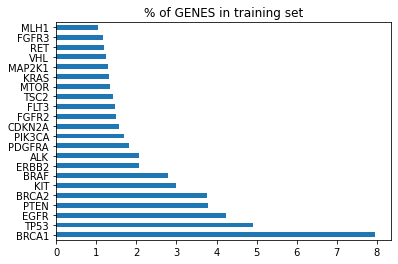

In [11]:
%matplotlib inline
df=(train.Gene.value_counts(normalize=True)*100)
df[df>1].plot(kind='barh',title='% of GENES in training set')

<AxesSubplot:title={'center':'% of GENES in test set'}>

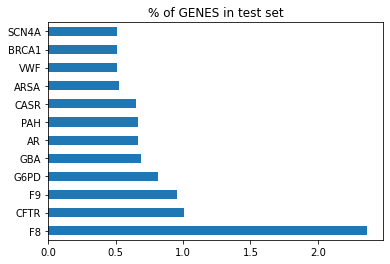

In [12]:
df=(test.Gene.value_counts(normalize=True)*100)
df[df>=0.5].plot(kind='barh',title='% of GENES in test set')

In [13]:
num_common_genes=set(train.Gene).intersection(set(test.Gene))
print( 'Common genes in train and test {0}'.format(len(num_common_genes)))

Common genes in train and test 154


<AxesSubplot:title={'center':'Class distribution in train set'}>

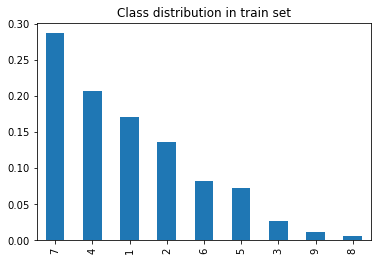

In [14]:
train.Class.value_counts(normalize=True).plot(kind='bar',title='Class distribution in train set')

#### Observation

- Class levels 3, 8, and 9 are notably under-represented
- Levels 5 and 6 are of comparable, medium-low frequency
- Levels 1, 2, and 4 are of comparable, medium-high frequency
- Level 7 is clearly the most frequent one

#### Gene vs. Variation

In [15]:
train_top=train.Gene.value_counts(normalize=True)*100
top_genes=train_top[train_top>1].index
uq=train.Class.unique()
train_top_genes=train[train.Gene.isin(top_genes)]
topGenes=train_top_genes.Gene.unique()

test_top_genes=test[test.Gene.isin(top_genes)]

In [16]:
train_top_genes['sod']='train'
test_top_genes['sod']='test'

df1=train_top_genes.loc[:,['ID','Gene','Variation','sod']].append(test_top_genes)
le = preprocessing.LabelEncoder()
var=le.fit_transform(df1.Variation)
le = preprocessing.LabelEncoder()
var=le.fit_transform(df1.Variation)
df1['Int_var']=var
df1.head()

,ID,Gene,Variation,sod,Int_var
138,138,EGFR,L747_T751delinsP,train,1022
139,139,EGFR,S752_I759del,train,1585
140,140,EGFR,I491M,train,780
141,141,EGFR,D770_P772dup,train,271
142,142,EGFR,G719A,train,643


In [17]:
train_top_genes=df1[df1.sod=='train'].sort_values(by='Gene')
test_top_genes=df1[df1.sod=='test'].sort_values(by='Gene')
df=train_top_genes.groupby(['Gene','Int_var'],as_index=False).ID.count()
df.head()

,Gene,Int_var,ID
0,ALK,4,1
1,ALK,8,1
2,ALK,14,1
3,ALK,93,1
4,ALK,96,1


#### Data distribution

<AxesSubplot:xlabel='Gene', ylabel='Int_var'>

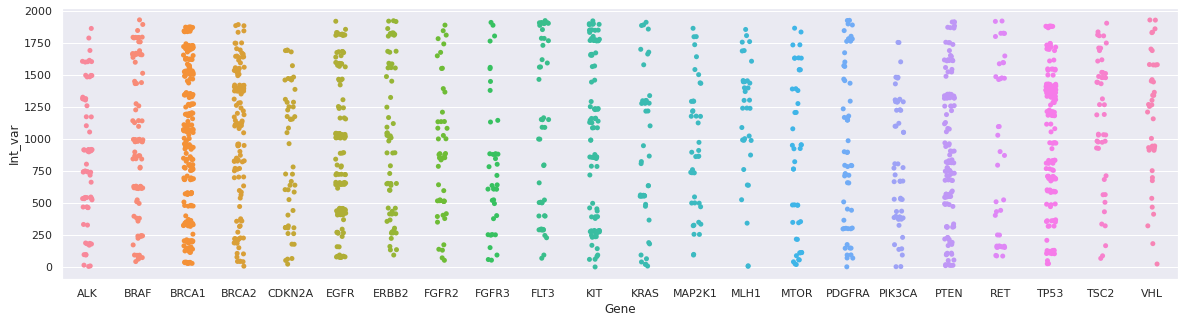

In [18]:
import seaborn as sns
sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = (20,5)

sns.stripplot(x="Gene", y="Int_var", data=train_top_genes)
#sns.plt.suptitle('Train title versus variation ')

<AxesSubplot:xlabel='Gene', ylabel='Int_var'>

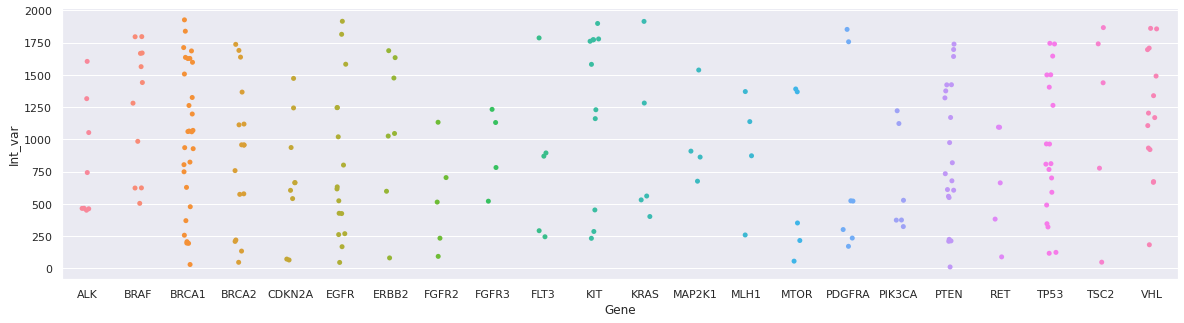

In [19]:
sns.stripplot(x="Gene", y="Int_var", data=test_top_genes)

#### Text data

In [20]:
train=train.merge(train_text)
test=test.merge(test_text)
print(train.shape)
print(test.shape)
train.Text.head()

(3321, 5)
(5668, 4)


0    Cyclin-dependent kinases (CDKs) regulate a var...
1     Abstract Background  Non-small cell lung canc...
2     Abstract Background  Non-small cell lung canc...
3    Recent evidence has demonstrated that acquired...
4    Oncogenic mutations in the monomeric Casitas B...
Name: Text, dtype: object

In [21]:
train.iloc[0].Text[0:1000]

'Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1